In [25]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scipy import stats

# Setup

In [2]:
## Load and filter the data. NMJ (Neuromuscular Junction) connections are not part of the brain network, so we exclude them.
df = pd.read_csv('/Users/simone/Documents/PhD/graph_theory_project/data/NeuronConnect.csv', sep=';')
df_brain = df[df['Type'] != 'NMJ'].copy()

print(f"Original records: {len(df)}")
print(f"Brain network records (excluding NMJ): {len(df_brain)}")
print(f"Edge types found: {df_brain['Type'].unique()}")

Original records: 6417
Brain network records (excluding NMJ): 6264
Edge types found: <StringArray>
['EJ', 'Sp', 'R', 'Rp', 'S']
Length: 5, dtype: str


In [3]:
## Create a directed graph from the brain connectivity data.
G = nx.DiGraph()
for _, row in df_brain.iterrows():
    u = row['Neuron 1']
    v = row['Neuron 2']
    w = row['Nbr'] # Weight (number of connections)
    etype = row['Type']
    
    # Add edge u -> v
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
    
    # If it is a Gap Junction (EJ), also add v -> u
    if etype == 'EJ':
        if G.has_edge(v, u):
            G[v][u]['weight'] += w
        else:
            G.add_edge(v, u, weight=w)

print(f"Number of Nodes (N): {G.number_of_nodes()}")
print(f"Number of Edges (E): {G.number_of_edges()}")

Number of Nodes (N): 279
Number of Edges (E): 4577


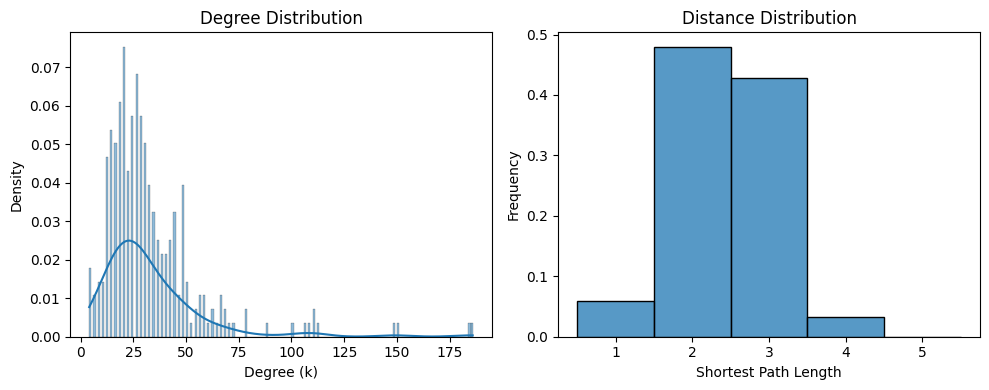

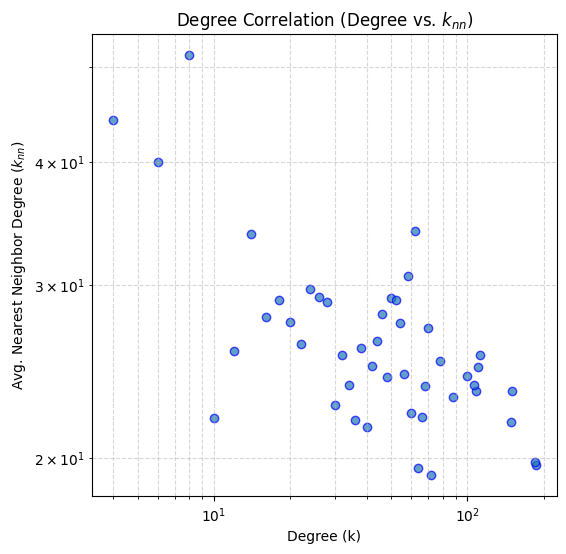

Network is strongly connected.
------------------------------
Average Degree: 32.81
Average Clustering Coefficient: 0.3371
Average Path Length: 2.4356
Diameter: 5
------------------------------


In [ ]:
###  Considering the overall nematode brain network (gap junction + synapse) calculate the degree distribution, the distance distribution, the node degree correlation (you can plot the degree vs. knn as shown in class), the clustering, the diameter.

# Check if G is directed to choose the correct connectivity function
is_directed = G.is_directed()

# --- 1. Degree Distribution ---
# If directed, we usually look at In/Out separately, but Total Degree is also valid
degrees = [d for n, d in G.degree()]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # Set up the first spot in a 1x2 grid
sns.histplot(degrees, kde=True, stat="density", binwidth=1)
plt.title("Degree Distribution")
plt.xlabel("Degree (k)")
plt.ylabel("Density")

# --- 2. Distance Distribution ---
# Collect all shortest path lengths
all_shortest_paths = []
for source in G.nodes():
    paths = nx.shortest_path_length(G, source=source)
    # Filter out distance to self (0)
    all_shortest_paths.extend([length for target, length in paths.items() if target != source])

avg_path_length = np.mean(all_shortest_paths)

plt.subplot(1, 2, 2) # Set up the second spot
sns.histplot(all_shortest_paths, discrete=True, stat="density")
plt.title("Distance Distribution")
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('degree_distance_distribution.png', dpi=300)
plt.show()

# --- 3. Node Degree Correlation (Degree vs. Knn) ---
# [cite_start]Calculates average nearest neighbor degree for nodes with degree k [cite: 1348]
knn_dict = nx.average_degree_connectivity(G) 
k = list(knn_dict.keys())
knn = list(knn_dict.values())

plt.figure(figsize=(6, 6))
plt.scatter(k, knn, alpha=0.7, edgecolors='b')
plt.title("Degree Correlation (Degree vs. $k_{nn}$)")
plt.xlabel("Degree (k)")
plt.ylabel("Avg. Nearest Neighbor Degree ($k_{nn}$)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.savefig('degree_knn_correlation.png', dpi=300)
plt.show()

# --- 4. Clustering & Diameter ---
avg_clustering = nx.average_clustering(G)

# Handle Diameter based on graph connectivity
diameter = None
largest_cc_size = 0

if is_directed:
    if nx.is_strongly_connected(G):
        diameter = nx.diameter(G)
        print("Network is strongly connected.")
    else:
        # Calculate on Largest Strongly Connected Component
        largest_scc = max(nx.strongly_connected_components(G), key=len)
        G_sub = G.subgraph(largest_scc)
        diameter = nx.diameter(G_sub)
        largest_cc_size = len(largest_scc)
        print(f"Network is not strongly connected. Using LSCC ({largest_cc_size} nodes).")
else:
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print("Network is connected.")
    else:
        # Calculate on Largest Connected Component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
        largest_cc_size = len(largest_cc)
        print(f"Network is not connected. Using LCC ({largest_cc_size} nodes).")

# --- Printouts ---
print("-" * 30)
print(f"Average Degree: {np.mean(degrees):.2f}") # [cite: 1205]
print(f"Average Clustering Coefficient: {avg_clustering:.4f}") # [cite: 1379]
print(f"Average Path Length: {avg_path_length:.4f}") # [cite: 1312]
print(f"Diameter: {diameter}") # [cite: 1298]
print("-" * 30)

# Fit the distributions (degree and distance) focusing on the tail

<>:32: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:32: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
/var/folders/3p/shj2kb9x3jjdx507cm6pndgc0000gn/T/ipykernel_44972/1690397191.py:32: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
  plt.plot(k_tail, 10**(intercept + slope * log_k), 'r--', linewidth=2, label=f'Fit: $\gamma$ = {gamma:.2f}')


--- Degree Distribution Analysis ---
Power Law Exponent (gamma): 1.44
R-squared: 0.7790
Interpretation: A linear relationship in the log-log plot indicates a Scale-Free network[cite: 842].
The exponent gamma corresponds to the slope of the line[cite: 844].
----------------------------------------


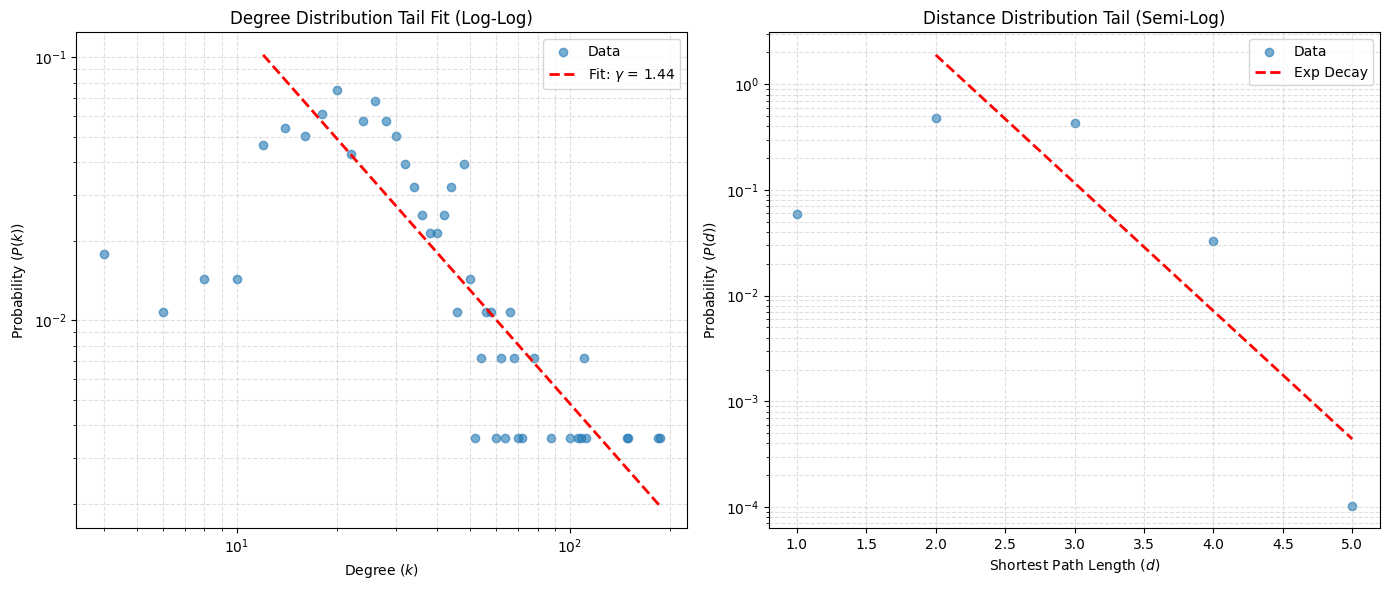

--- Distance Distribution Analysis ---
Max Distance (Diameter): 5
Interpretation: Small-world networks typically have short path lengths (L << N)[cite: 753].
A rapid decay in the tail indicates the network is globally compact.


In [16]:
# Get degrees (using total degree for overall connectivity)
degrees = np.array([d for n, d in G.degree()])
k_min = 1  # Filter out degree 0 to avoid log(0)

# Calculate frequencies
degree_counts = np.bincount(degrees)
k_values = np.nonzero(degree_counts)[0]
p_k = degree_counts[k_values] / sum(degree_counts) # Probability P(k)

# --- Define Tail for Fitting ---
# We visually select a cutoff or fit the whole range if it looks linear in log-log.
tail_cutoff = 11 
tail_indices = np.where(k_values >= tail_cutoff)

k_tail = k_values[tail_indices]
p_tail = p_k[tail_indices]

# Log-Log Transformation 
log_k = np.log10(k_tail)
log_p = np.log10(p_tail)

# Linear Regression: log(P(k)) = -gamma * log(k) + c
slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_p)
gamma = -slope

# Plotting
plt.figure(figsize=(14, 6))

# Plot 1: Degree Distribution (Log-Log)
plt.subplot(1, 2, 1)
plt.scatter(k_values, p_k, alpha=0.6, label='Data')
plt.plot(k_tail, 10**(intercept + slope * log_k), 'r--', linewidth=2, label=f'Fit: $\gamma$ = {gamma:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree ($k$)')
plt.ylabel('Probability ($P(k)$)')
plt.title('Degree Distribution Tail Fit (Log-Log)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

# Comments on Degree Results
print("--- Degree Distribution Analysis ---")
print(f"Power Law Exponent (gamma): {gamma:.2f}")
print(f"R-squared: {r_value**2:.4f}")
print("Interpretation: A linear relationship in the log-log plot indicates a Scale-Free network[cite: 842].")
print("The exponent gamma corresponds to the slope of the line[cite: 844].")
print("-" * 40)

## DISTANCE DISTRIBUTION - TAIL INSPECTION

# Collect all path lengths
all_path_lengths = []
for n in G.nodes():
    paths = nx.shortest_path_length(G, source=n)
    all_path_lengths.extend([length for target, length in paths.items() if target != n])

# Calculate Frequencies
dist_counts = np.bincount(all_path_lengths)
d_values = np.nonzero(dist_counts)[0]
p_d = dist_counts[d_values] / sum(dist_counts)

# Fitting the tail (Exponential decay often used for "long tails" in distance)
# We look for linearity in a Semi-Log plot (log(P(d)) vs d)
tail_dist_cutoff = 2 # Example: Fit distances >= 2
tail_dist_indices = np.where(d_values >= tail_dist_cutoff)

d_tail = d_values[tail_dist_indices]
p_d_tail = p_d[tail_dist_indices]

# Semi-Log Transformation
log_p_d = np.log10(p_d_tail)

# Linear Regression
slope_d, intercept_d, r_value_d, _, _ = stats.linregress(d_tail, log_p_d)

# Plot 2: Distance Distribution (Semi-Log)
plt.subplot(1, 2, 2)
plt.scatter(d_values, p_d, alpha=0.6, label='Data')
plt.plot(d_tail, 10**(intercept_d + slope_d * d_tail), 'r--', linewidth=2, label=f'Exp Decay')
plt.yscale('log') # Semi-log plot
plt.xlabel('Shortest Path Length ($d$)')
plt.ylabel('Probability ($P(d)$)')
plt.title('Distance Distribution Tail (Semi-Log)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

plt.tight_layout()
plt.savefig('distance_distribution_tail_fit.png', dpi=300)
plt.show()

# Comments on Distance Results
print("--- Distance Distribution Analysis ---")
print(f"Max Distance (Diameter): {np.max(all_path_lengths)}")
print("Interpretation: Small-world networks typically have short path lengths (L << N)[cite: 753].")
print("A rapid decay in the tail indicates the network is globally compact.")

# Null model analysis

In [ ]:
# --- 1. Setup Empirical Metrics ---
# To ensure fair comparison, let's calculate empirical L on the LSCC as well
# (Random graphs often fracture, so LSCC is the standard stable metric)
if G.is_directed():
    largest_cc = max(nx.strongly_connected_components(G), key=len)
else:
    largest_cc = max(nx.connected_components(G), key=len)

G_sub = G.subgraph(largest_cc)
L_empirical = nx.average_shortest_path_length(G_sub)
C_empirical = nx.average_clustering(G)

print(f"Empirical Network: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
print(f"Empirical L (LSCC): {L_empirical:.4f}")
print(f"Empirical C: {C_empirical:.4f}")

# --- 2. Randomization (Null Model) ---
n_realizations = 100
N = G.number_of_nodes()
E = G.number_of_edges()
is_directed = G.is_directed()

rand_C = []
rand_L = []

print(f"\nGenerating {n_realizations} ER random graphs...")

for i in range(n_realizations):
    # Generate ER graph (G(N, M) model matches exact edge count)
    ER = nx.gnm_random_graph(N, E, directed=is_directed)
    
    # 1. Clustering
    rand_C.append(nx.average_clustering(ER))
    
    # 2. Path Length (Computed on LSCC to handle disconnected graphs)
    if is_directed:
        if nx.is_strongly_connected(ER):
            rand_L.append(nx.average_shortest_path_length(ER))
        else:
            er_largest_cc = max(nx.strongly_connected_components(ER), key=len)
            if len(er_largest_cc) > 1:
                rand_L.append(nx.average_shortest_path_length(ER.subgraph(er_largest_cc)))
    else:
        if nx.is_connected(ER):
            rand_L.append(nx.average_shortest_path_length(ER))
        else:
            er_largest_cc = max(nx.connected_components(ER), key=len)
            if len(er_largest_cc) > 1:
                rand_L.append(nx.average_shortest_path_length(ER.subgraph(er_largest_cc)))

# --- 3. Statistics & Analytical Comparison ---
mu_C = np.mean(rand_C)
std_C = np.std(rand_C)
mu_L = np.mean(rand_L)
std_L = np.std(rand_L)

# Analytical Predictions 
k_avg = (2 * E / N) if not is_directed else (E / N)
p_conn = k_avg / (N - 1)

C_analytical = p_conn  # C ~ p
L_analytical = np.log(N) / np.log(k_avg) if k_avg > 1 else 0

print("-" * 40)
print(f"{'Metric':<10}  | {'Empirical':<10} | {'Random (Mean)':<15} | {'Analytical':<10} | {'Z-Score':<10}")
print("-" * 40)

# Z-Scores
z_C = (C_empirical - mu_C) / std_C if std_C > 0 else 0
z_L = (L_empirical - mu_L) / std_L if std_L > 0 else 0

print(f"{'Cluster (C)':<10} | {C_empirical:<10.4f} | {mu_C:<15.4f} | {C_analytical:<10.4f} | {z_C:<10.2f}")
print(f"{'PathLen (L)':<10} | {L_empirical:<10.4f} | {mu_L:<15.4f} | {L_analytical:<10.4f} | {z_L:<10.2f}")
print("-" * 40)

# Interpretation Logic
if C_empirical > mu_C and abs(z_L) < 10: # L is roughly comparable, C is much higher
    print("Result: Small-World Network (High Clustering, Short Path Length)")
elif C_empirical <= mu_C and abs(z_L) < 2:
    print("Result: Random-Like Network")
else:
    print("Result: Regular/Lattice-Like or Other Topology")

Empirical Network: Nodes=279, Edges=4577
Empirical L (LSCC): 2.4356
Empirical C: 0.3371

Generating 100 ER random graphs...
----------------------------------------
Metric     | Empirical  | Random (Mean)   | Analytical | Z-Score   
----------------------------------------
Cluster (C) | 0.3371     | 0.0590          | 0.0590     | 364.96    
PathLen (L) | 2.4356     | 2.2988          | 2.0129     | 60.34     
----------------------------------------
Result: Regular/Lattice-Like or Other Topology


# Community detection

Detected 7 communities.
Modularity (Q): 0.5061
Sizes of largest communities: [84, 73, 51, 31, 17]


/var/folders/3p/shj2kb9x3jjdx507cm6pndgc0000gn/T/ipykernel_44972/1620241589.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_comms) if num_comms > 10 else cm.get_cmap('tab10', num_comms)


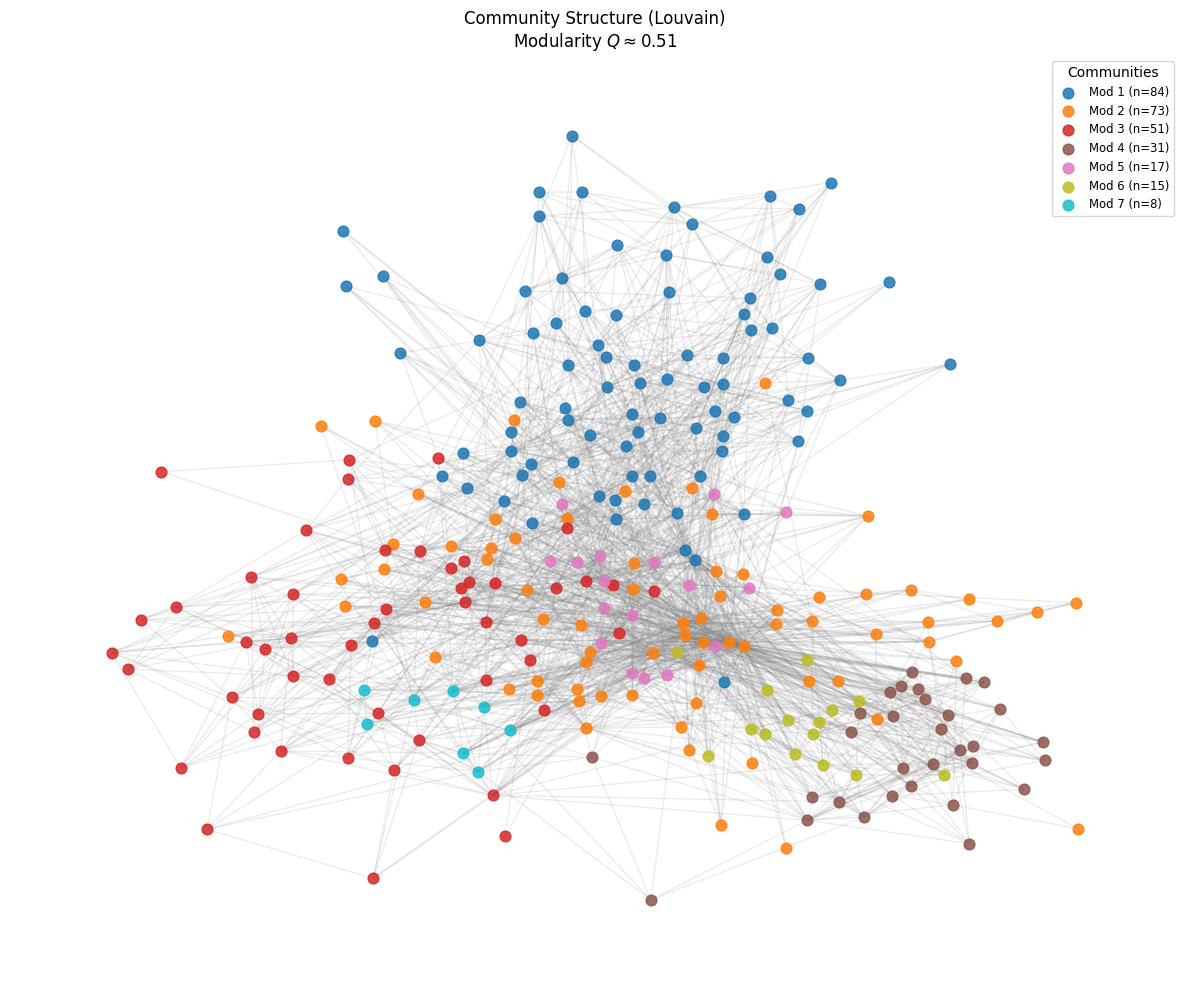

Plot saved to figs/community_structure.png


In [ ]:
# --- 1. Community Detection (Louvain Method) ---
# Louvain is a heuristic method to maximize Modularity 
# It generally works on undirected graphs.
G_undirected = G.to_undirected()

try:
    from networkx.algorithms.community import louvain_communities, modularity
    
    # Detect communities
    communities = louvain_communities(G_undirected, seed=42)
    print(f"Detected {len(communities)} communities.")
    
    # Calculate Modularity (Q)
    # This matches the formula Q = (1/2m) * sum(...) 
    Q_score = modularity(G_undirected, communities)
    print(f"Modularity (Q): {Q_score:.4f}")
    
    # Sort communities by size
    communities = sorted(communities, key=len, reverse=True)
    top_sizes = [len(c) for c in communities[:5]]
    print(f"Sizes of largest communities: {top_sizes}")

except ImportError:
    print("Louvain algorithm not available. Please install/upgrade networkx or python-louvain.")
    communities = []
    Q_score = 0

# --- 2. Visualization ---
def plot_community_structure(G, communities, filename="figs/community_structure.png"):
    """
    Visualizes the network with nodes colored by their community.
    """
    if not communities:
        return

    # Create a map of node -> community index
    partition = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            partition[node] = idx
            
    plt.figure(figsize=(12, 10))
    # Use spring layout for clustering visualization
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)
    
    # Setup Colors
    # Using 'tab10' or 'tab20' for distinct community colors
    num_comms = len(communities)
    cmap = cm.get_cmap('tab20', num_comms) if num_comms > 10 else cm.get_cmap('tab10', num_comms)
    
    # Draw nodes per community
    for idx, comm in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), 
                               node_size=60, 
                               node_color=[cmap(idx)], 
                               alpha=0.85,
                               label=f"Mod {idx+1} (n={len(comm)})")
                               
    # Draw edges (light/thin for background)
    nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='gray')

    plt.title(f"Community Structure (Louvain)\nModularity $Q \\approx {Q_score:.2f}$")
    plt.axis('off')
    
    # Legend for the top largest communities to avoid clutter
    handles, labels = plt.gca().get_legend_handles_labels()
    # Limit legend to top 10 if too many
    plt.legend(handles[:10], labels[:10], loc='upper right', title="Communities", fontsize='small')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Plot saved to {filename}")

# Run the plot
plot_community_structure(G_undirected, communities)